#Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/MyDrive/dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

#Data Preprocessing

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np 
from keras_preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
import itertools 
import matplotlib.pyplot as plt
import dill as pickle
%matplotlib inline

In [4]:
train_dir = '/content/train'
test_dir ='/content/test'

In [5]:
def append_ext(fn):
    return fn+".jpg"

In [6]:
traindf = pd.read_csv('/content/labels.csv', dtype=str)
testdf = pd.read_csv('/content/sample_submission.csv', dtype=str)

In [7]:
traindf["id"] = traindf["id"].apply(append_ext)
testdf["id"] = testdf["id"].apply(append_ext)

In [8]:
included_breed = ['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever',
                  'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
for index,breed in traindf.iterrows():
    if breed[1] not in included_breed:
        traindf= traindf.drop([index])
traindf.shape

(841, 2)

In [9]:
traindf.head()

,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever
9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
20,008b1271ed1addaccf93783b39deab45.jpg,doberman
25,00a366d4b4a9bbb6c8a63126697b7656.jpg,golden_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897.jpg,golden_retriever


In [10]:
datagen = ImageDataGenerator( rescale=1./255.,
                              rotation_range = 20,
                              brightness_range=[0.2,1.0],
                              width_shift_range = 0.2,
                              height_shift_range = 0.2,
                              horizontal_flip = True,
                              validation_split=0.1
                              )

In [11]:
BATCH_SIZE = 32
image_size=(224,224)

In [12]:
train_generator  =    datagen.flow_from_dataframe(
                                                  dataframe=traindf,
                                                  directory=train_dir,
                                                  x_col="id",
                                                  y_col="breed",
                                                  subset="training",
                                                  batch_size=BATCH_SIZE,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=image_size,
                                                  color_mode="rgb" 
                                                  )

Found 757 validated image filenames belonging to 10 classes.


In [13]:
x,y = next(train_generator)
print(type(x))
print(x.shape)
print(y.shape)

<class 'numpy.ndarray'>
(32, 224, 224, 3)
(32, 10)


In [14]:
def show_grid(image_list,nrows,ncols,figsize=(10,10),showaxis='off'):
    
    image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,                                                   # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),                                 # creates 2x2 grid of axes
                     axes_pad=0.3,                                               # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')                                  # The AxesGrid object work as a list of axes.
        ax.axis('off')

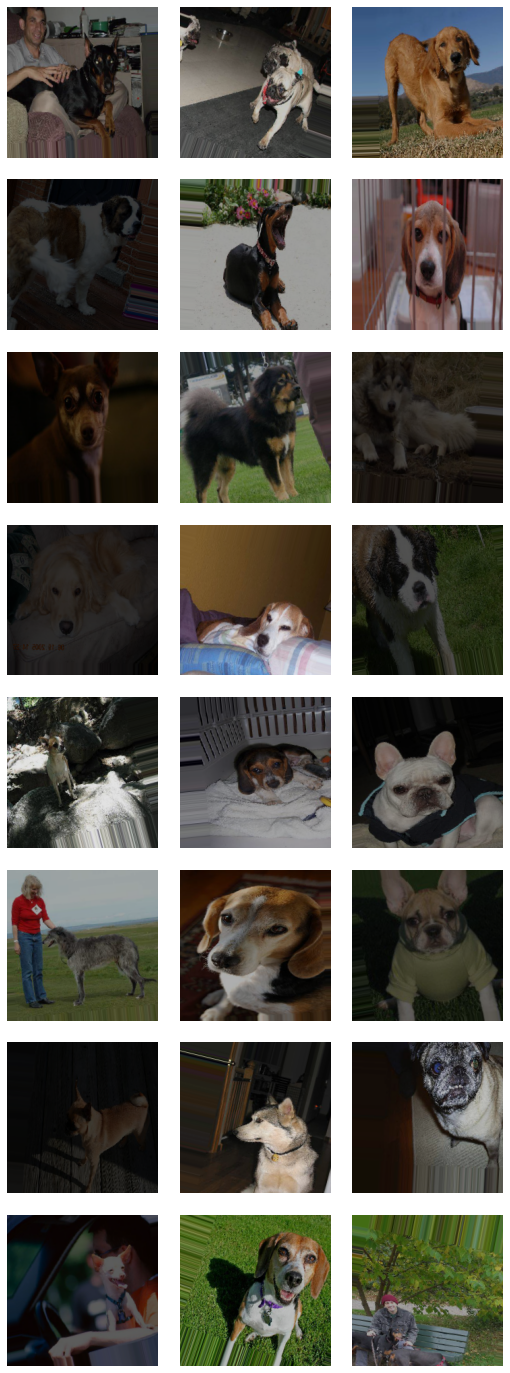

In [15]:
show_grid(x,8,3,figsize=(25,25))

In [16]:
valid_generator   =   datagen.flow_from_dataframe(
                                                  dataframe=traindf,
                                                  directory=train_dir,
                                                  x_col="id",
                                                  y_col="breed",
                                                  subset="validation",
                                                  batch_size=BATCH_SIZE,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=image_size,
                                                  color_mode="rgb")

Found 84 validated image filenames belonging to 10 classes.


In [17]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
                                                dataframe=testdf,
                                                directory=test_dir,
                                                x_col="id",
                                                y_col=None,
                                                batch_size=BATCH_SIZE,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=image_size,
                                                color_mode="rgb")

Found 10357 validated image filenames.


In [18]:
shape=(224,224,3)

In [19]:
classes = len(included_breed)
classes

10

In [20]:
pretrained_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False ,
        input_shape=shape
    )
    
model = tf.keras.Sequential([ 
        pretrained_model,  
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

94674944/94668760 [==============================] - 1s 0us/step


In [21]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred): 
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [22]:
opt = tf.keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer= opt , loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1

In [23]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                   )

Epoch 1/20
23/23 [==============================] - 55s 718ms/step - loss: 3.8181 - acc: 0.1903 - f1_m: 0.1662 - precision_m: 0.2127 - recall_m: 0.1379 - val_loss: 1.4036 - val_acc: 0.5000 - val_f1_m: 0.4766 - val_precision_m: 0.9333 - val_recall_m: 0.3281
Epoch 2/20
23/23 [==============================] - 14s 585ms/step - loss: 2.1603 - acc: 0.3352 - f1_m: 0.2897 - precision_m: 0.4691 - recall_m: 0.2114 - val_loss: 1.2483 - val_acc: 0.6406 - val_f1_m: 0.5482 - val_precision_m: 0.7624 - val_recall_m: 0.4375
Epoch 3/20
23/23 [==============================] - 14s 585ms/step - loss: 1.7634 - acc: 0.4083 - f1_m: 0.3792 - precision_m: 0.6245 - recall_m: 0.2754 - val_loss: 0.8007 - val_acc: 0.7656 - val_f1_m: 0.7447 - val_precision_m: 0.9706 - val_recall_m: 0.6094
Epoch 4/20
23/23 [==============================] - 14s 588ms/step - loss: 1.2787 - acc: 0.5641 - f1_m: 0.5467 - precision_m: 0.7610 - recall_m: 0.4283 - val_loss: 0.5266 - val_acc: 0.8438 - val_f1_m: 0.8204 - val_precision_m: 0.

In [24]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Saved model to disk


In [25]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10 == 1: 
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

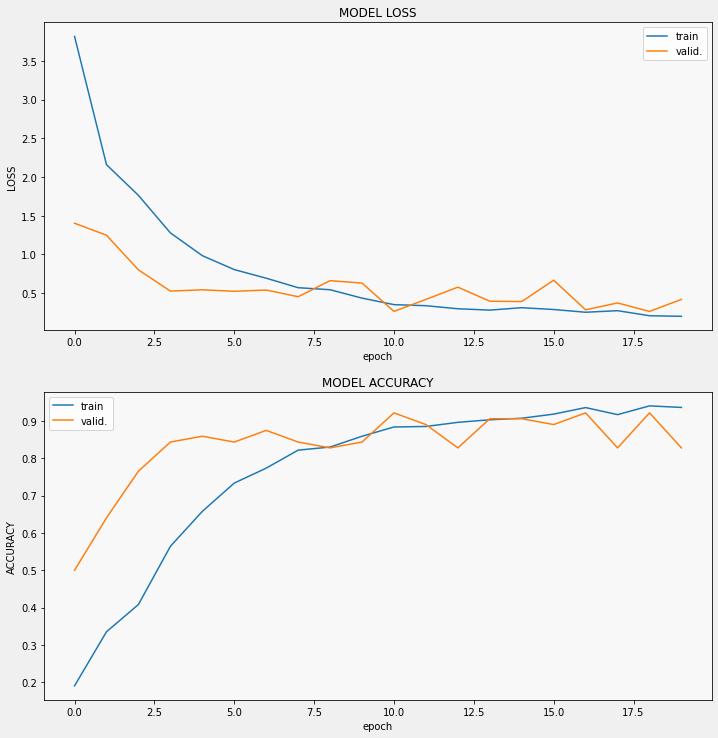

In [26]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)

display_training_curves(
    history.history['acc'],
    history.history['val_acc'],
    'ACCURACY',
    212,
)

In [27]:
loss, accuracy, f1_score, precision, recall = model.evaluate(valid_generator,batch_size=32)

print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

3/3 [==============================] - 2s 788ms/step - loss: 0.2432 - acc: 0.9048 - f1_m: 0.9189 - precision_m: 0.9344 - recall_m: 0.9042
Loss: 0.24317918717861176
Accuracy: 0.9047619104385376
F1 Score: 0.9188768267631531


In [28]:
df_submission = pd.read_csv('/content/sample_submission.csv', usecols= included_breed+['id'])
df_submission.head()

,id,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [29]:
pred=model.predict(test_generator)

In [30]:
df_submission.iloc[:,1:] = pred
df_submission.head()

,id,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
0,000621fb3cbb32d8935728e48679680e,5.961236e-02,0.164448,3.553137e-02,0.017671,4.875854e-01,0.101170,0.016420,3.031898e-02,4.693104e-02,0.040313
1,00102ee9d8eb90812350685311fe5890,1.939078e-03,0.007721,4.172996e-03,0.031939,1.281001e-02,0.366725,0.012009,1.855751e-03,2.034231e-02,0.540486
2,0012a730dfa437f5f3613fb75efcd4ce,3.026620e-03,0.043570,6.188517e-02,0.011494,4.408954e-01,0.083927,0.012173,3.059824e-02,2.443884e-01,0.068042
3,001510bc8570bbeee98c8d80c8a95ec1,1.677763e-10,0.000001,3.845439e-07,0.000013,2.855430e-07,0.000007,0.999957,4.532059e-07,3.434352e-08,0.000020
4,001a5f3114548acdefa3d4da05474c2e,6.438790e-08,0.000792,2.322531e-05,0.002463,2.516175e-06,0.000091,0.851768,2.675450e-04,1.126535e-02,0.133327
